# Neural Network

Pada proses classification menggunakan model Neural Network dengan menggunakan data sentimen teks Twitter (Text Mining). Sebelum dilakukan proses preprocessing terlebih dahulu mengimport library yang digunakan

### Import Library

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Load Data

Berikut ini merupakan data kotor dari data teks Sentimen

### Data Kotor Sentimen

In [2]:
df = pd.read_csv('train_preprocess.tsv.txt',sep="\t", names = ['Kalimat','Label'])

In [3]:
df

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#### Checking Missing Values

In [4]:
df.isnull().sum()

Kalimat    0
Label      0
dtype: int64

Tidak ada data yang kosong atau bernilai null (Nan)

#### Checking Duplicate Value

In [5]:
df.duplicated().sum()

67

Terdapat 67 data yang bernilai lebih dari satu. Oleh karena itu proses selanjutnya data tsb di drop sehingga tidak ada data yang bernilai lebih dari satu

In [6]:
df = df.drop_duplicates(ignore_index=True)
df.duplicated().sum()

0

In [7]:
df

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10928,f - demokrat dorong upaya kemandirian energi n...,neutral
10929,tidak bosan,positive
10930,enak rasa masakan nya apalagi kepiting yang me...,positive
10931,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#### Checking Data based on Label

In [8]:
df.Label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

Setelah dilakukan checking missing value dan data duplicate diperoleh bahwa data sentimen twitter (df) memiliki :
- Kalimat Positive sebanyak 6382 kalimat
- Kalimat Negatif sebanyak 3412 kalimat
- Kalimat Netral sebanyak 1138 kalimat

In [9]:
print('Jumlah kalimat:',df.Label.value_counts().sum())

Jumlah kalimat: 10933


### Download Dict of Stopwords

Sebelum di lakukan proses normalisasi pada text mining yaitu proses cleansing dibutuhkan suatu kamus yang berisi kata-kata yang tidak memiliki makna atau arti yang disebut sebagai stopword

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salwainasshabira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords 

kamus_stopword = stopwords.words('indonesian')
more_stopword = ['sih','nya', 'iya', 'nih', 'biar', 'tau', 'kayak', 'banget','ya','gue','rt','RT','amp']
kamus_stopword = kamus_stopword+more_stopword

df_stopword = pd.DataFrame(kamus_stopword)
df_stopword = df_stopword.rename(columns={0:'stopword'})

not_stopwords = {'tidak'} 
final_stop_words = set([word for word in kamus_stopword if word not in not_stopwords])

### Kamus Alay

Pada proses cleansing digunakan suatu data yang berisikan kumpulan kata-kata alay yang dapat direplace atau digantikan dengan kata yang formal atau arti sebenarnya

In [12]:
df_kamusalay = pd.read_csv('new_kamusalay (1).csv',encoding = 'latin-1', header=None)
df_kamusalay = df_kamusalay.rename(columns={0: 'Original', 1: 'Arti'})
df_kamusalay

,Original,Arti
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit
15166,megangin,memegang
15167,mmbri,memberi


In [13]:
new_kamusalay = {'Original':'Pemandngan', 'Arti':'Pemandangan'}
df_kamusalay = df_kamusalay.append(new_kamusalay, ignore_index=True)
df_kamusalay

,Original,Arti
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15165,memetwit,mentwit
15166,megangin,memegang
15167,mmbri,memberi
15168,diwlh,dipilih


### Cleansing Processes

In [14]:
import re
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import TweetTokenizer

stem = StemmerFactory()
stemmer = stem.create_stemmer()

def lowercase(teks):
    teks_baru = teks.lower()
    return teks_baru

def stemming(teks):
    return stemmer.stem(teks)

def replacement_alay(teks):
    kamusalay_map = dict(zip(df_kamusalay['Original'], df_kamusalay['Arti']))
    for word in kamusalay_map:
        return ' '.join([kamusalay_map[word] if word in kamusalay_map else word for word in teks.split(' ')])

def remove_stopword(teks):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(teks)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in final_stop_words): # remove punctuation
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
    return " ".join(tweets_clean)

def remove_worduncess(teks):
    teks = re.sub('k212',' ', teks)
    teks = re.sub(r':',' ', teks) #Menghilangkan tanda baca :
    teks = re.sub('[0-9]+',' ', teks) #Menghilangkan angka-angka
    teks = re.sub('\n',' ',teks) #Menghilangkan tab
    teks = re.sub('  +',' ',teks) #Menghilangkan ekstra spasi
    teks = re.sub(r'#', '', teks) #Menghilangkan hashtag
    teks = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',teks) #Menghilangkan link/web
    return teks
                        
def remove_punctuation(teks):
    teks = re.sub(r'[^\w\s]',' ',teks) #Menghilangkan tanda baca
    teks = re.sub(' +',' ',teks)
    return teks

def remove_user(teks):
    teks = re.sub('user',' ',teks) #Menghilangkan kata user
    teks = re.sub('  +',' ',teks) #Menghilangkan ekstra spasi
    return teks

def remove_emoticon(teks):
    teks = teks.replace(' \ ', ' ')
    teks = re.sub('x..', ' ', teks)
    teks = re.sub(' \n', ' ', teks)
    teks = re.sub('\+', ' ', teks)
    teks = re.sub(' +',' ', teks)
    teks = re.sub(r'\$\w*',' ',teks)
    return teks

def cleansing(teks):
    teks = lowercase(teks)
    teks = stemming(teks)
    teks = remove_stopword(teks)
    teks = remove_user(teks)
    teks = remove_emoticon(teks)
    teks = remove_worduncess(teks)
    teks = remove_punctuation(teks)
    teks = replacement_alay(teks)
    return teks

### Hasil Cleansing Data Sentimen

In [15]:
df['Kalimat_Bersih'] = df['Kalimat'].apply(cleansing)
df

,Kalimat,Label,Kalimat_Bersih
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus memberi hujjah partai dipili...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nyaman ...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unbo tidak paket barang bagus beli
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
...,...,...,...
10928,f - demokrat dorong upaya kemandirian energi n...,neutral,f demokrat dorong upaya mandiri energi nasional
10929,tidak bosan,positive,tidak bosan
10930,enak rasa masakan nya apalagi kepiting yang me...,positive,enak masakan kepiting senang pilih kepiting se...
10931,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi tol pasteur macet parah bikin jengkel


### Hasil Cleansing berdasarkan Wordcloud

#### Word in All Statement

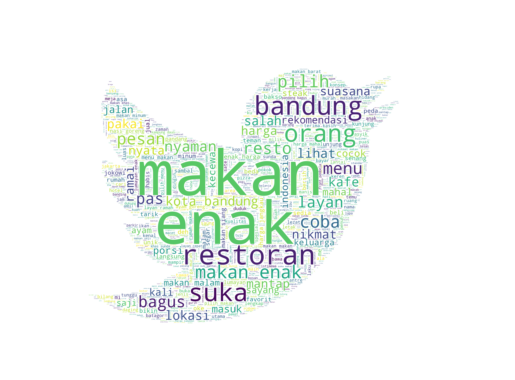

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from wordcloud import WordCloud

text =' '.join(df['Kalimat_Bersih'])
mask = np.array(Image.open('twitter bird.jpeg'))
wordcloud = WordCloud(stopwords=kamus_stopword, width=2000,height=1000,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42).generate(text)

# Generate plot
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Word in Positive Statement

In [17]:
df_positive = df[df['Label']=="positive"]
df_positive

,Kalimat,Label,Kalimat_Bersih
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nyaman ...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unbo tidak paket barang bagus beli
5,"makanan beragam , harga makanan di food stall ...",positive,makan agam harga makan food stall kasir suasan...
7,"tempat unik , bagus buat foto , makanan enak ,...",positive,unik bagus foto makan enak pegawai ramah bersi...
...,...,...,...
10925,datang ke sini sore hari pakai baju agak tebal...,positive,sore pakai baju tebal dingin akses sulit jalan...
10927,kalau memang jala nya sudah begitu terima saja...,positive,jala terima ikhlas
10929,tidak bosan,positive,tidak bosan
10930,enak rasa masakan nya apalagi kepiting yang me...,positive,enak masakan kepiting senang pilih kepiting se...


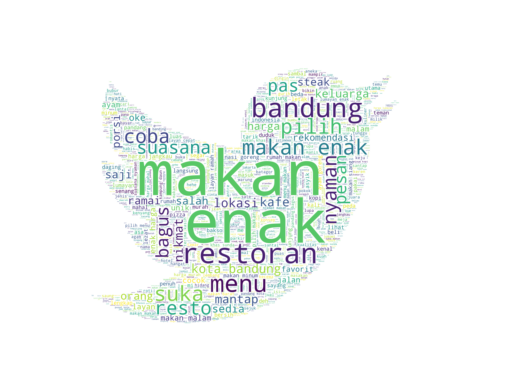

In [18]:
# Visualisasi Wordcloud
text =' '.join(df_positive['Kalimat_Bersih'])
mask = np.array(Image.open('twitter bird.jpeg'))
wordcloud = WordCloud(stopwords=kamus_stopword, width=2000,height=1000,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42).generate(text)

# Generate plot
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Word in Negative Statement

In [19]:
df_negative = df[df['Label']=="negative"]
df_negative

,Kalimat,Label,Kalimat_Bersih
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
6,pakai kartu kredit bca tidak untung malah rugi...,negative,pakai kartu kredit baca tidak untung rugi
10,simcard indosat inaktiv gara-gara lupa isi pul...,negative,simcard indosat inaktiv gara gara lupa isi pul...
11,sifat iri sering muncul pada orang orang yang ...,negative,sifat iri muncul orang orang tidak tuju hidup
13,"pengalaman bersama indosat hari ini , semoga t...",negative,alam indosat semoga tidak langgan marah layan ...
...,...,...,...
10917,tolong dibaca pesan saya ! di dalam kotak hand...,negative,tolong baca pesan kotak handphone tidak kartu ...
10920,"sumpah gue kecewa banget dengan sms , cuma tea...",negative,sumpah kecewa sms teaser doang isi got eh pas ...
10924,tadinya pengin mengantar teman dari kalau ke r...,negative,ingin teman resto hit bandung rekomendasi ah s...
10926,dapat rom awal abad,negative,rom abad


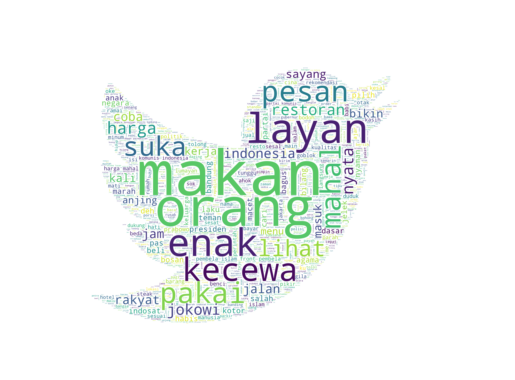

In [20]:
# Visualisasi Wordcloud
from PIL import Image
import numpy as np
from wordcloud import WordCloud

text =' '.join(df_negative['Kalimat_Bersih'])
mask = np.array(Image.open('twitter bird.jpeg'))
wordcloud = WordCloud(stopwords=kamus_stopword, width=2000,height=1000,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42).generate(text)

# Generate plot
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Word in Neutral Statement

In [21]:
df_neutral = df[df['Label']=="neutral"]
df_neutral

,Kalimat,Label,Kalimat_Bersih
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus memberi hujjah partai dipili...
16,setiap bumn dibentuk dengan uu bukan dibentuk ...,neutral,badan usaha milik negara bentuk undang undang ...
28,pdip sebut ridwan kamil menang karena berbaju ...,neutral,partai demokrasi indonesia perjuangan ridwan k...
32,08:30 : kedatangan presiden ri dan rombongan d...,neutral,presiden ri rombong gate terminal sambut ment...
37,risma menjatuhkan pilihan nya pada gus ipul - ...,neutral,risma jatuh pilih gus ipul puti pilihan gubern...
...,...,...,...
10820,demokrat umumkan calon gubri jagoan di menit t...,neutral,demokrat calon gubri jago menit
10863,pkb benarkan charly setia band daftar jadi caw...,neutral,partai kebangkitan bangsa charly setia band da...
10903,pernah percaya kalau body lotion citra bikin b...,neutral,percaya body lotion citra bikin bulu
10905,"bu susi marah , menteri luhut perbolehkan kapa...",neutral,bu sus marah menteri luhut kapal asing curi ik...


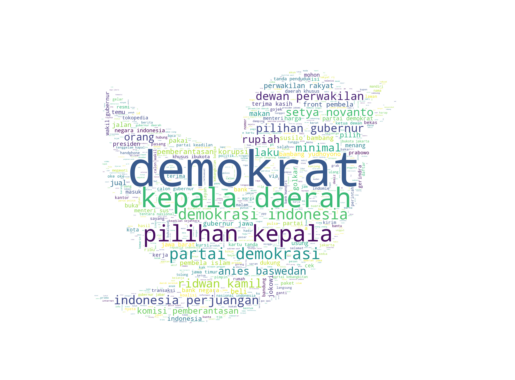

In [22]:
# Visualisasi Wordcloud
text =' '.join(df_neutral['Kalimat_Bersih'])
mask = np.array(Image.open('twitter bird.jpeg'))
wordcloud = WordCloud(stopwords=kamus_stopword, width=2000,height=1000,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42).generate(text)

# Generate plot
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Count Word Output Cleansing

In [23]:
from collections import Counter
df['word_list'] = df['Kalimat_Bersih'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['word','count']
temp.style.background_gradient(cmap='Blues')

,word,count
0,makan,6481
1,tidak,4425
2,enak,3728
3,harga,2018
4,bandung,1748
5,menu,1719
6,restoran,1289
7,layan,1268
8,pilih,1096
9,jalan,988


In [24]:
from collections import Counter
df_positive['word_list'] = df_positive['Kalimat_Bersih'].apply(lambda x:str(x).split())
top_positive = Counter([item for sublist in df_positive['word_list'] for item in sublist])
temp_positive = pd.DataFrame(top_positive.most_common(10))
temp_positive.columns = ['word','count']
temp_positive.style.background_gradient(cmap='Blues')

,word,count
0,makan,5747
1,enak,3460
2,tidak,2363
3,harga,1718
4,bandung,1633
5,menu,1572
6,restoran,1154
7,suasana,932
8,pilih,927
9,layan,921


In [25]:
from collections import Counter
df_negative['word_list'] = df_negative['Kalimat_Bersih'].apply(lambda x:str(x).split())
top_negative = Counter([item for sublist in df_negative['word_list'] for item in sublist])
temp_negative = pd.DataFrame(top_negative.most_common(10))
temp_negative.columns = ['word','count']
temp_negative.style.background_gradient(cmap='Blues')

,word,count
0,tidak,1964
1,makan,700
2,orang,465
3,layan,330
4,indonesia,322
5,harga,277
6,enak,264
7,mahal,254
8,kamu,253
9,kecewa,244


In [26]:
from collections import Counter
df_neutral['word_list'] = df_neutral['Kalimat_Bersih'].apply(lambda x:str(x).split())
top_neutral = Counter([item for sublist in df_neutral['word_list'] for item in sublist])
temp_neutral = pd.DataFrame(top_neutral.most_common(10))
temp_neutral.columns = ['word','count']
temp_neutral.style.background_gradient(cmap='Blues')

,word,count
0,indonesia,157
1,partai,128
2,demokrat,102
3,tidak,98
4,daerah,98
5,gubernur,95
6,pilihan,92
7,kepala,65
8,bank,60
9,jawa,57


## Modelling for classification use MLPClassifier

### Import Library

Langka pertama dilakukan adalah mengimport library yang digunakan dalam proses classification dengan Neural Network:

1. Pickle = library yang digunakan untuk melakukan pembobotan pada tiap kata yang dimiliki dengan menggunakan metode verktorisasi hasil pembobotan disimpan dan dibaca ke dalam atau dari suatu file berformat .pkl.

2. Scipy = library yang digunakan untuk memecahkan masalah matematika, ilmiah, teknik, dan teknis.

3. Scikit-Learn (Sklearn) = Library yang digunakan pada Machine Learning yaitu untuk membuat model classification.

In [27]:
import pickle
import scipy
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

### Feature Extraction menggunakan TF-IDF

In [28]:
data_cleansing_sentimen = df['Kalimat_Bersih'].tolist()
data_cleansing_sentimen

['warung milik usaha pabrik puluh kenal putih bandung kualitas padu ahli masak padu kretivitas warung saji menu utama bahan menu ayam selera indonesia harga jangkau bletoka tidak kalah asli tegal',
 'mohon ulama lurus memberi hujjah partai dipilih suara islam tidak pecah',
 'lokasi strategis jalan sumatra bandung nyaman utama sofa lantai paella enak pas makan minum bir dingin appetiser enak',
 'betapa bahagia unbo tidak paket barang bagus beli',
 'aduh mahasiswa sombong kasih kartu kuning ajar tidak politik selesai kuliah politik tidak telat dasar mahasiswa',
 'makan agam harga makan food stall kasir suasana ramai perhati parkir duduk',
 'pakai kartu kredit baca tidak untung rugi',
 'unik bagus foto makan enak pegawai ramah bersih luas wifi kencang harga standar sesuai menu masakan makan barat indonesia menu favorit lychee mojito spagheti',
 'keluarga nikmat alam kuliner senang rm sari sunda jalan setiabudhi bandung tidak hubung rm sari sunda jalan setiabudhi tulis maaf rekan baca bing

In [29]:
tfid_vect = TfidfVectorizer()
tfid_vect.fit(data_cleansing_sentimen)

X_tfid = tfid_vect.transform(data_cleansing_sentimen)

with open('feature_xnn_tfidf.pickle', 'wb') as handle:
    pickle.dump(tfid_vect, handle,protocol=pickle.HIGHEST_PROTOCOL)
    print("feature_xnn_tfidf has created!")

feature_xnn_tfidf has created!


In [30]:
X_tfid

<10933x11826 sparse matrix of type '<class 'numpy.float64'>'
	with 150393 stored elements in Compressed Sparse Row format>

In [31]:
classes = df['Label']
Y = classes
Y

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10928     neutral
10929    positive
10930    positive
10931    negative
10932    positive
Name: Label, Length: 10933, dtype: object

In [32]:
df_label = pd.DataFrame(Y.value_counts()).reset_index().rename(columns={"index": "Label"})
df_label.columns.values[1]='Count'
display(df_label)

,Label,Count
0,positive,6383
1,negative,3412
2,neutral,1138


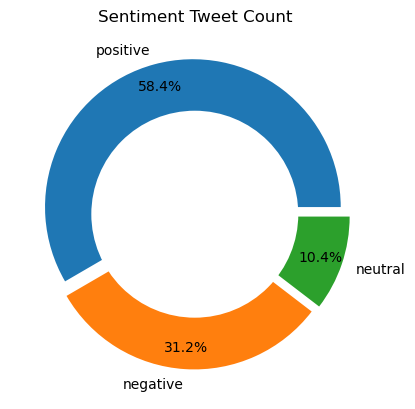

In [33]:
import matplotlib.pyplot as plt

# explosion
explode = (0.05, 0.05, 0.05)

# Pie Chart
plt.pie(df_label['Count'], labels=df_label['Label'],
		autopct='%1.1f%%', pctdistance=0.85,
		explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Sentiment Tweet Count')

# Displaying Chart
plt.show()


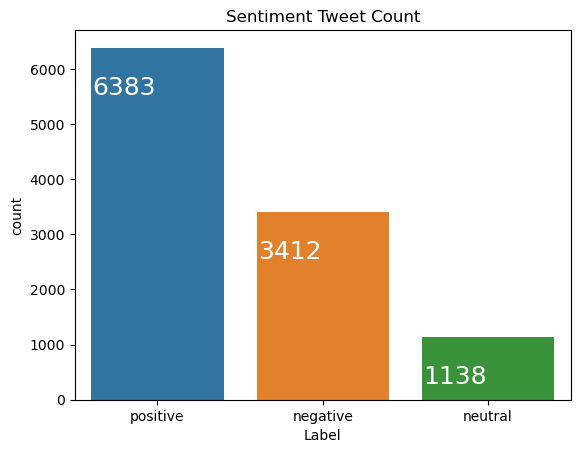

In [34]:
import seaborn as sns
ax = sns.countplot(x=df["Label"],order = df["Label"].value_counts(ascending=False).index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)

plt.title('Sentiment Tweet Count')
plt.show()

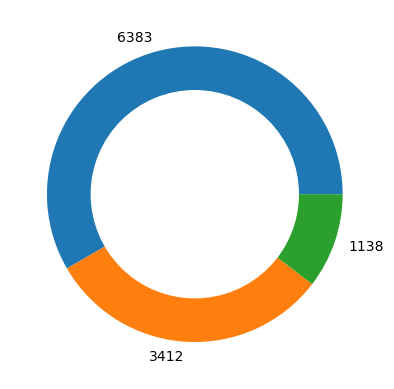

In [35]:
data = df['Label'].value_counts()
explode = (0, 0, 0)
plt.pie(data, explode = explode, labels = [round(i,2) for i in (list(data))])
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [36]:
Y

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10928     neutral
10929    positive
10930    positive
10931    negative
10932    positive
Name: Label, Length: 10933, dtype: object

In [37]:
with open('y_labels.pickle','wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created1!")

y_labels.pickle has created1!


#### Preparing train dan test dataset , 20% sebagai data test 80% sebagai data train

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfid, Y, test_size=0.2)

## Training

In [39]:
model = MLPClassifier()
model.fit(X_train, Y_train)
print('Training Selesai')

Training Selesai


In [40]:
pickle.dump(model, open("model_nn.pickle",'wb'))

In [41]:
load_model = pickle.load(open("model_nn.pickle", 'rb'))
result = load_model.score(X_test, Y_test)

In [42]:
load_model

MLPClassifier()

In [43]:
Y_test

9418      neutral
10431    positive
8584     positive
3014     positive
643      positive
           ...   
7414     negative
10734    positive
5790     positive
5890     negative
693      negative
Name: Label, Length: 2187, dtype: object

## Evaluation Data Test

In [44]:
test = model.predict(X_test)
print("Testing Selesai")

print("\n",classification_report(Y_test, test))

test_acc = accuracy_score(Y_test, test)
test_F1 = f1_score(Y_test, test, pos_label=['positive','negative','neutral'],
                                           average='macro')
test_precision = precision_score(Y_test, test,pos_label=['positive','negative','neutral'],
                                           average='macro')
test_recall = recall_score(Y_test, test,pos_label=['positive','negative','neutral'],
                                           average='macro')

print("Accuracy Score Test : ",test_acc)
print("F1 Score Test : ",test_F1)
print("Precision Score Test : ",test_precision)
print("Recall Score Test : ",test_recall)

Testing Selesai

               precision    recall  f1-score   support

    negative       0.71      0.75      0.73       633
     neutral       0.75      0.51      0.61       246
    positive       0.86      0.89      0.87      1308

    accuracy                           0.81      2187
   macro avg       0.78      0.72      0.74      2187
weighted avg       0.80      0.81      0.80      2187

Accuracy Score Test :  0.8052126200274349
F1 Score Test :  0.7379382617797505
Precision Score Test :  0.7750626691400978
Recall Score Test :  0.7167518241337464


## Evaluation Data Train

In [45]:
train = model.predict(X_train)
train_acc = accuracy_score(Y_train, train)

print("\n",classification_report(Y_train, train))
print("Accuracy Score Train: ",train_acc)


               precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2779
     neutral       1.00      1.00      1.00       892
    positive       1.00      1.00      1.00      5075

    accuracy                           1.00      8746
   macro avg       1.00      1.00      1.00      8746
weighted avg       1.00      1.00      1.00      8746

Accuracy Score Train:  0.9994283100846101


## Confusion Matrix

### Pada Data sentimen yang telah di cleansing diperoleh ConfusionMatrix berikut ini:

In [46]:
confusion_matrix = metrics.confusion_matrix(Y_test, test)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negative', 'neutral','positive'])

In [47]:
confusion_matrix

array([[ 476,   15,  142],
       [  67,  126,   53],
       [ 123,   26, 1159]])

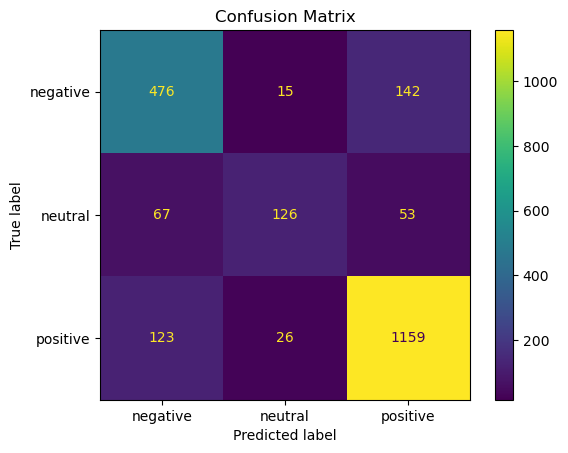

In [48]:
import matplotlib.pyplot as plt

cm.plot()
plt.title("Confusion Matrix")
plt.show()

## Cross Validation

In [49]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []
score_f1 = []
score_preci = []
score_rcall = []

y = classes

for i, data in enumerate(kf.split(X_tfid), start=1):

    data_train   = X_tfid[data[0]]
    target_train = y[data[0]]

    data_test    = X_tfid[data[1]]
    target_test  = y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # for the current fold only    
    accuracy = accuracy_score(target_test, preds)
    F1 = f1_score(preds,target_test, pos_label=['positive','negative','neutral'],
                                           average='macro')
    precision = precision_score(preds,target_test,pos_label=['positive','negative','neutral'],
                                           average='macro')
    recall = recall_score(preds,target_test,pos_label=['positive','negative','neutral'],
                                           average='macro')

    print("Training ke-", i)
    print(sklearn.metrics.classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)
    score_f1.append(F1)
    score_preci.append(precision)
    score_rcall.append(recall)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)
average_f1 = np.mean(score_f1)
average_precision = np.mean(score_preci)
average_recall= np.mean(score_rcall)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,6))
print("Rata-rata F1-Score : ", round(average_f1,6))
print("Rata-rata Precision : ", round(average_precision,6))
print("Rata-rata Recall : ", round(average_recall,6))

Training ke- 1
              precision    recall  f1-score   support

    negative       0.76      0.73      0.74       690
     neutral       0.70      0.59      0.64       220
    positive       0.85      0.89      0.87      1277

    accuracy                           0.81      2187
   macro avg       0.77      0.74      0.75      2187
weighted avg       0.81      0.81      0.81      2187

Training ke- 2
              precision    recall  f1-score   support

    negative       0.77      0.74      0.76       667
     neutral       0.75      0.58      0.65       219
    positive       0.86      0.91      0.88      1301

    accuracy                           0.83      2187
   macro avg       0.79      0.74      0.76      2187
weighted avg       0.82      0.83      0.82      2187

Training ke- 3
              precision    recall  f1-score   support

    negative       0.75      0.74      0.74       695
     neutral       0.74      0.54      0.62       213
    positive       0.85      0

## Predict

In [50]:
original_text = "sedih banget"

text = tfid_vect.transform([cleansing(original_text)])

result = model.predict(text)[0]
print("Sentimen:",result)

Sentimen: negative


<function matplotlib.pyplot.show(close=None, block=None)>

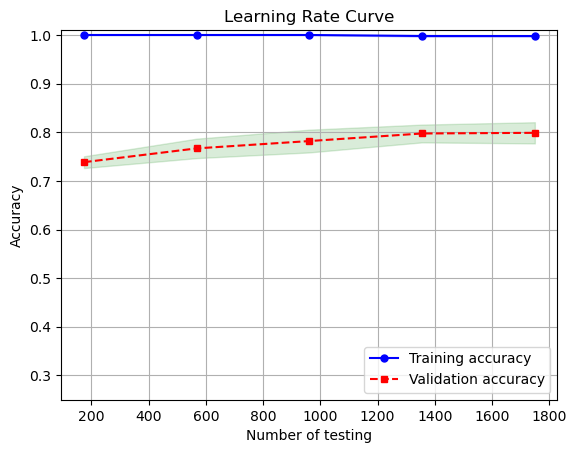

In [51]:
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

train_sizes, train_scores, test_scores =\
    learning_curve(estimator = model, X = X_test, y = Y_test)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color = "blue", marker = 'o',
         markersize = 5,label  ='Training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std, 
                 train_mean - train_std,
                 alpha=0.15, color = 'blue')

plt.plot(train_sizes, test_mean, 
         color='red', linestyle = '--',
         marker = 's',markersize = 5, 
         label = 'Validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std, 
                 test_mean - test_std,
                 alpha=0.15, color = 'green')
    

plt.grid()
plt.title("Learning Rate Curve")
plt.xlabel('Number of testing')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.25, 1.01])
plt.show